In [1]:
import sys
sys.path.append("..")
import importlib
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

import system.from_higher_basis_truncation_tunable_full_cosine as system
importlib.reload(system)
import utils.solver as solver
importlib.reload(solver)
import pulse.tukey as tukey
importlib.reload(tukey)
import pulse.tukey_derivative as tukey_derivative
importlib.reload(tukey_derivative)
import utils.expectation_values as expect
importlib.reload(expect)
import optimization.grape as grape
importlib.reload(grape)
import utils.graph as graph
importlib.reload(graph)

pass

# known
1. Drive system with tukey pulse
2. Look at floquet basis during flat top driving period
3. Plot population of floquet states as a function of time over the existing plot

# exploratory
1. Figure out how floquet state relates to our original basis
    1. specifically could we stop driving sooner to achieve the same resolution


8.067223706634019


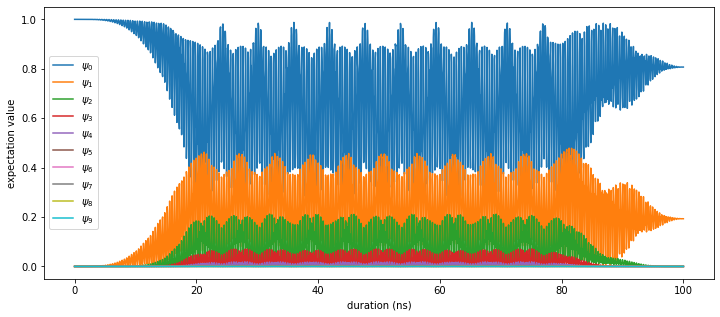

In [52]:
amp = 2.5 * 2 * np.pi
offset = 0.25
freq = system.first_energy_spacing/3 - offset # angular GHz
print(freq)
rc = 0.5
dur = 100
tlist = np.linspace(0, dur, dur*20)
tukey.setup(amp, freq, rc, tlist)

solution = solver.time_evolve(system.H0, system.H1, tukey.pulse_func, tlist, system.basis_states[0], pbar=True)

graph.graph_solution(solution, system)

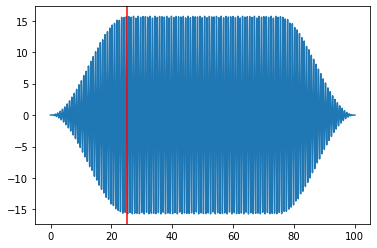

In [25]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

percent_starting_ramp = rc /2
time_end_starting_ramp = dur * percent_starting_ramp
time_start_ending_ramp = dur - time_end_starting_ramp # symmetric
index_at_starting_ramp = find_nearest(tlist, time_end_starting_ramp)

plt.plot(tlist, tukey.get_pulse(tlist))
plt.axvline(time_end_starting_ramp, c='red')
plt.show()

state_at_start_of_steady_state = solution.states[index_at_starting_ramp]

In [53]:
import qutip.floquet as floquet
# find the floquet modes for the time-dependent hamiltonian
H = [system.H0, [system.H1, tukey.pulse_func]]
period = 2*np.pi / (freq/2*np.pi)
f_modes_0, f_energies = floquet.floquet_modes(H, period)

# decompose the inital state in the floquet modes
f_coeff = floquet.floquet_state_decomposition(f_modes_0, f_energies, state_at_start_of_steady_state)

In [54]:
# calculate the wavefunctions using the from the floquet modes
fstates = []
tlist = np.linspace(time_end_starting_ramp, 100, 100*10)
for t in tlist:
    fstates.append(floquet.floquet_wavefunction_t(f_modes_0, f_energies, f_coeff, t, H, period))

expect_values = expect.get_all_expectation_values(fstates, system.basis_states)


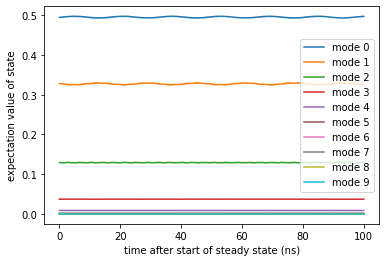

In [55]:
for i in range(0, len(expect_values)):
    plt.plot(tlist, expect_values[i], label=r'mode %i' % i)
plt.xlabel("time after start of steady state (ns)")
plt.ylabel("expectation value of state")
plt.legend()
plt.show()

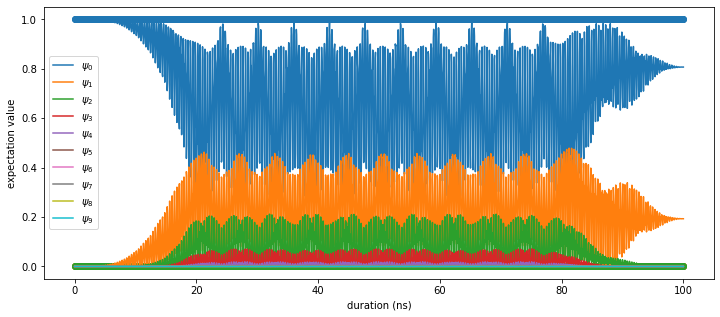

In [58]:
graph.graph_solution(solution, system)

for i in range(0, len(expect_values)-7):
    plt.scatter(tlist, expect_values[i], label=r'mode %i' % i)



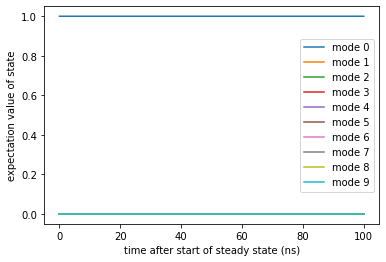

In [57]:
# lets try the whole damn thing in floquet space
# clearly is not supposed to work, and it doesnt

H = [system.H0, [system.H1, tukey.pulse_func]]
period = 2*np.pi / (freq/2*np.pi)
f_modes_0, f_energies = floquet.floquet_modes(H, period)
f_coeff = floquet.floquet_state_decomposition(f_modes_0, f_energies, system.basis_states[0])

# calculate the wavefunctions using the from the floquet modes
fstates = []
tlist = np.linspace(0, 100, 100*10)
for t in tlist:
    fstates.append(floquet.floquet_wavefunction_t(f_modes_0, f_energies, f_coeff, t, H, period))

expect_values = expect.get_all_expectation_values(fstates, system.basis_states)

for i in range(0, len(expect_values)):
    plt.plot(tlist, expect_values[i], label=r'mode %i' % i)
plt.xlabel("time after start of steady state (ns)")
plt.ylabel("expectation value of state")
plt.legend()
plt.show()